# Intro to PySpark

## RDD API

In [1]:
# imports
from pyspark.sql import SparkSession
from pyspark.rdd import RDD
from typing import Iterable, Tuple, List

# namespace the built-in Spark functions (https://spark.apache.org/docs/latest/api/sql/index.html)
import pyspark.sql.functions as F
import pyspark.sql.types as T

import matplotlib.pyplot as plt

%matplotlib inline

Let's do a simple opration: WordCount. For a set of data, generate the counts of the words

In [2]:
# create a new spark instance in local mode
spark = SparkSession.builder.config('spark.jars.packages', 'org.xerial:sqlite-jdbc:3.40.0.0').getOrCreate()
sc = spark.sparkContext

22/11/28 23:49:06 WARN Utils: Your hostname, mjt5v resolves to a loopback address: 127.0.1.1; using 192.168.1.169 instead (on interface wlo1)
22/11/28 23:49:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/usr/local/lib/python3.10/dist-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/mjt5v/.ivy2/cache
The jars for the packages stored in: /home/mjt5v/.ivy2/jars
org.xerial#sqlite-jdbc added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a0b93167-7b13-439f-8d72-add14df52a86;1.0
	confs: [default]
	found org.xerial#sqlite-jdbc;3.40.0.0 in central
:: resolution report :: resolve 98ms :: artifacts dl 2ms
	:: modules in use:
	org.xerial#sqlite-jdbc;3.40.0.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-a0b93167-7b13-439f-8d72-add14df52a86
	confs: [default]

22/11/28 23:49:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
input_file = sc.textFile('words.txt')

In [4]:
# get each word from each line using flatmap
words = input_file.flatMap(lambda line: line.split(" "))

In [5]:
# key each word by the word and give it a value of 1
word_counts = words.map(lambda word: (word, 1))

In [6]:
from operator import add
total_word_counts = word_counts.reduceByKey(add)

In [7]:
total_word_counts.sortBy(lambda t: -t[1]).collect()

[('as', 8),
 ('they', 7),
 ('', 3),
 ('are', 2),
 ('beautiful', 2),
 ('walk', 1),
 ('only', 1),
 ('share.', 1),
 ('people', 1),
 ('not', 1),
 ('look,', 1),
 ('or', 1),
 ('talk.', 1),
 ('love,', 1),
 ('care', 1)]

Let's do a simple operation: [PageRank](https://en.wikipedia.org/wiki/PageRank). This computes the relative importance of the nodes in a graph based on the number of links to each node in graph. It's based off of paper publications. The most important papers have the most citations and the citations of the highly cicated papers must also be important. Papers with few or no citations must not be important. This logic was applied to websites with the most linked to sites being the most important/relevant sites to users' queries.

In [8]:
def process_csv_line(line: str) -> List[Tuple[str, str]]:
    # csv is an edge list of nodes
    split = line.split('\t')
    # source is in position 0
    if len(split) < 2:
        return []
    src_node = split[0]
    return [(src_node, node) for node in split[1:]]

In [9]:
def process_joined_items(t: Tuple[Iterable, float]) -> Iterable[float]:
    urls = list(t[0])
    rank = t[1]
    size = len(urls)
    return [(url, rank/size) for url in urls]

In [10]:
num_iterations = 10
url_lines = sc.textFile('small.txt')
processed_lines = url_lines.flatMap(process_csv_line)
# cache links to avoid recomputation. links is the set of edges
links = processed_lines.distinct().groupByKey().cache()
# create initial rankings of nodes -> everyone has equal importance of 1.0
ranks = links.mapValues(lambda v: 1.0)
for i in range(num_iterations):
    contributions: RDD[Tuple[str, float]] = links.join(ranks).values().flatMap(process_joined_items)
    ranks = contributions.reduceByKey(add).mapValues(lambda v: 0.15 + 0.05 * v)
ranks.sortBy(lambda t: -t[1]).collect()

[('8709207', 0.16857962456468017),
 ('11287582', 0.16249889088021205),
 ('8553535', 0.1609825294907101),
 ('9650960', 0.1609235947123398),
 ('11044077', 0.1608135159639584),
 ('12610128', 0.1594673675409078),
 ('12518224', 0.15796660624101402),
 ('12857908', 0.1577162694962722),
 ('11160736', 0.1577051356721794),
 ('12663788', 0.15618622290615136),
 ('9420209', 0.15617153556067026),
 ('12560332', 0.15479671394094455),
 ('11886254', 0.15470528801795128),
 ('10873782', 0.15456185916454604),
 ('11163673', 0.1531542140516886),
 ('11878901', 0.1531242155751464),
 ('9568045', 0.15312344750439316),
 ('9784363', 0.15312344750439316),
 ('8289365', 0.15309309670410756),
 ('7491757', 0.15304608248219315),
 ('11158207', 0.15303030303030302),
 ('11883199', 0.15303030303030302),
 ('7933109', 0.15168579624565265),
 ('9018146', 0.15159467367541357),
 ('7831768', 0.15157966606241446),
 ('10233949', 0.15157716269496435),
 ('12050360', 0.15157716269496435),
 ('11602792', 0.15157716269496435),
 ('10364381

# Spark SQL

Let's some database queries like before

In [11]:
car_df = spark.read.format('jdbc').options(url='jdbc:sqlite:tutorial.db', dbtable='Car', driver='org.sqlite.JDBC').load()

In [12]:
engineer_df = spark.read.format('jdbc').options(url='jdbc:sqlite:tutorial.db', dbtable='Engineer', driver='org.sqlite.JDBC').load()

In [13]:
car_df.printSchema()

root
 |-- Pk_Car_Id: long (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Model: string (nullable = true)



In [14]:
engineer_df.printSchema()

root
 |-- Pk_Engineer_Id: long (nullable = true)
 |-- FullName: string (nullable = true)
 |-- MobileNo: string (nullable = true)
 |-- Fk_Car_Id: long (nullable = true)



In [15]:
car_df.head()

Row(Pk_Car_Id=1, Brand='Benz', Model='GLK350')

In [16]:
engineer_df.head()

Row(Pk_Engineer_Id=50, FullName='Elvis Young', MobileNo='08038888888', Fk_Car_Id=2)

## Engineers working on cars

In [17]:
car_df.join(engineer_df, car_df['Pk_Car_Id'] == engineer_df['Fk_Car_Id']).select(['Brand', 'Model', 'FullName', 'MobileNo']).collect()

[Row(Brand='Benz', Model='GLK350', FullName='Bola Johnson', MobileNo='08020000000'),
 Row(Brand='Benz', Model='GLK350', FullName='Kalu Ikechi', MobileNo='09098888888'),
 Row(Brand='Benz', Model='GLK350', FullName='Smart Wonodu', MobileNo='08185555555'),
 Row(Brand='Benz', Model='GLK350', FullName='Umaru Suleja', MobileNo='08056676666'),
 Row(Brand='Toyota', Model='Camry XLE', FullName='Elvis Young', MobileNo='08038888888')]

## Benz engineers

In [18]:
car_df.join(engineer_df, car_df['Pk_Car_Id'] == engineer_df['Fk_Car_Id']).where(F.col("Brand") == "Benz").select(['Brand', 'Model', 'FullName', 'MobileNo']).collect()

[Row(Brand='Benz', Model='GLK350', FullName='Bola Johnson', MobileNo='08020000000'),
 Row(Brand='Benz', Model='GLK350', FullName='Kalu Ikechi', MobileNo='09098888888'),
 Row(Brand='Benz', Model='GLK350', FullName='Smart Wonodu', MobileNo='08185555555'),
 Row(Brand='Benz', Model='GLK350', FullName='Umaru Suleja', MobileNo='08056676666')]

## Students

In [19]:
student_df = spark.read.format('jdbc').options(url='jdbc:sqlite:tutorial.db', dbtable='Student', driver='org.sqlite.JDBC').load()

In [20]:
class_df = spark.read.format('jdbc').options(url='jdbc:sqlite:tutorial.db', dbtable='Class', driver='org.sqlite.JDBC').load()

In [21]:
scr_df = spark.read.format('jdbc').options(url='jdbc:sqlite:tutorial.db', dbtable='StudentClassRelation', driver='org.sqlite.JDBC').load()

In [22]:
student_df.join(scr_df, student_df['StudentID'] == scr_df['StudentID']).join(class_df, scr_df['ClassID'] == class_df['ClassID']).select(['Name', 'Course']).collect()

[Row(Name='Amarachi Chinda', Course='History'),
 Row(Name='Olu Alfonso', Course='History'),
 Row(Name='Amarachi Chinda', Course='Biology'),
 Row(Name='Amarachi Chinda', Course='Physics'),
 Row(Name='Olu Alfonso', Course='Chemistry'),
 Row(Name='Olu Alfonso', Course='English')]

### or just use SQL

In [23]:
student_df.createOrReplaceTempView("Student")
class_df.createOrReplaceTempView("Class")
scr_df.createOrReplaceTempView("SCR")

In [24]:
spark.sql("SELECT s.Name, c.Course FROM Student s JOIN SCR sc ON s.StudentID = sc.StudentID JOIN Class c ON c.ClassID = sc.ClassID").collect()

[Row(Name='Amarachi Chinda', Course='History'),
 Row(Name='Olu Alfonso', Course='History'),
 Row(Name='Amarachi Chinda', Course='Biology'),
 Row(Name='Amarachi Chinda', Course='Physics'),
 Row(Name='Olu Alfonso', Course='Chemistry'),
 Row(Name='Olu Alfonso', Course='English')]

# Full E-Commerce Tutorial

Taken from [datacamp.com](https://www.datacamp.com/tutorial/pyspark-tutorial-getting-started-with-pyspark)

In [25]:
df = spark.read.csv('online_retail.csv', header=True, escape="\"")

## Exploratory Data Analysis

In [26]:
df.show(5, 0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+--------+------

The dataframe consists of 8 variables:

1. InvoiceNo: The unique identifier of each customer invoice.
2. StockCode: The unique identifier of each item in stock.
3. Description: The item purchased by the customer.
4. Quantity: The number of each item purchased by a customer in a single invoice.
5. InvoiceDate: The purchase date.
6. UnitPrice: Price of one unit of each item.
7. CustomerID: Unique identifier assigned to each user.
8. Country: The country from where the purchase was made

### Size of the data

In [27]:
df.count()

541909

In [28]:
## Descriptive stats
df.describe().toPandas()

,summary,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,count,541909,541909,540455,541909,541909,541909,406829,541909
1,mean,559965.752026781,27623.240210938104,20713.0,9.55224954743324,None,4.611113626089702,15287.690570239585,None
2,stddev,13428.417280797923,16799.737628427676,None,218.08115785023432,None,96.75985306117958,1713.6003033215952,None
3,min,536365,10002,4 PURPLE FLOCK DINNER CANDLES,-1,1/10/11 10:04,-11062.06,12346,Australia
4,max,C581569,m,wrongly sold sets,992,9/9/11 9:52,99.96,18287,Unspecified


In [29]:
df = df.where((df['Quantity'] >= 0) & (df['UnitPrice'] >= 0))

In [30]:
## Descriptive stats
df.describe().toPandas()

,summary,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,count,531283,531283,530691,531283,531283,531283,397924,531283
1,mean,559971.8861903847,27600.46057916311,None,10.655298588511208,None,3.89895361605878,15294.315170736121,None
2,stddev,13430.741723755973,16769.396933879452,None,156.8306171098148,None,35.87627885181999,1713.169877338221,None
3,min,536365,10002,4 PURPLE FLOCK DINNER CANDLES,1,1/10/11 10:32,0,12346,Australia
4,max,A563185,m,wrongly sold (22719) barcode,992,9/9/11 9:52,99.96,18287,Unspecified


### Number of unique customers

In [31]:
df.select('CustomerID').distinct().count()

4340

### Unique customers by country

In [32]:
df.groupBy('Country').agg(F.countDistinct('CustomerID').alias('country_count')).orderBy(F.desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3921|
|        Germany|           94|
|         France|           87|
|          Spain|           30|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           14|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|        Denmark|            9|
|         Cyprus|            8|
|          Japan|            8|
|         Sweden|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [33]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [34]:
df = df.withColumn('date', F.to_timestamp("InvoiceDate", 'MM/dd/yy HH:mm'))

### Min and max purchases

In [35]:
df.select([F.min('date'), F.max('date')]).show()


[Stage 98:>                                                         (0 + 8) / 8]



+-------------------+-------------------+
|          min(date)|          max(date)|
+-------------------+-------------------+
|2010-12-01 08:26:00|2011-12-09 12:50:00|
+-------------------+-------------------+




[Stage 98:====================================>                     (5 + 3) / 8]



## Customer Segmentation by Recency, Frequency and Monetary Value

[RFM](https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp) is commonly used in marketing to evaluate a client’s value based on their:

1. Recency: How recently has each customer made a purchase?
2. Frequency: How often have they bought something?
3. Monetary Value: How much money do they spend on average when making purchases?

### Calculate recency score per customer

In [36]:
df = df.withColumn('from_date', F.lit('12/01/10 08:26'))

In [37]:
df = df.withColumn('from_date', F.to_timestamp('from_date', 'MM/dd/yy HH:mm'))

In [38]:
recency_df = df.withColumn('recency', F.col("date").cast("long") - F.col('from_date').cast("long"))

### Get the most recent time offset

In [39]:
recency_df = recency_df.join(recency_df.groupBy('CustomerID').agg(F.max('recency').alias('recency')), on='recency', how='leftsemi')

In [40]:
recency_df.show(5, 0)

+-------+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |from_date          |
+-------+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|5220   |536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |12/1/10 9:53|6.45     |18074     |United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|5220   |536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |12/1/10 9:53|0.65     |18074     |United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|5220   |536384   |22464    |HANGING METAL HEART LANTERN        |12      |12/1/10 9:53|1.65     |18074     |United Kingdom|2010-12-01 09:53:00|2010-12-01 08:26:00|
|5220   |536384 

### Calculate Frequency

In [41]:
freq_df = recency_df.groupBy('CustomerID').agg(F.count('InvoiceDate').alias('frequency'))

In [42]:
freq_df.show(5, 0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|17714     |10       |
|17551     |43       |
|13187     |37       |
|15052     |30       |
|17128     |14       |
+----------+---------+
only showing top 5 rows




[Stage 108:=======>                                                 (1 + 7) / 8]



In [43]:
combined_freq_recency = recency_df.join(freq_df, on='CustomerID', how='inner')

### Total Amount spent

In [44]:
total_amt_df = combined_freq_recency.withColumn('TotalAmount', F.abs(F.col('Quantity')) * F.abs(F.col('UnitPrice')))

#### By customer

In [45]:
total_amt_df = total_amt_df.groupBy('CustomerID').agg(F.sum('TotalAmount').alias('monetary_value'))

In [46]:
final_df = total_amt_df.join(combined_freq_recency, on='CustomerID', how='inner')

### Final RFM dataframe

In [47]:
final_df = final_df.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [48]:
final_df.show(5)

+-------+---------+------------------+----------+
|recency|frequency|    monetary_value|CustomerID|
+-------+---------+------------------+----------+
|4586760|       10|             153.0|     17714|
|1230360|       43|            306.84|     17551|
|3148260|       37|236.01999999999995|     13187|
|4692360|       30|            215.78|     15052|
|3382560|       14|            157.09|     17128|
+-------+---------+------------------+----------+
only showing top 5 rows



## Standardization

In [49]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [50]:
# transform data into a single column feature vector for ML
assembler = VectorAssembler(inputCols=['recency', 'frequency', 'monetary_value'], outputCol='features')
assembled_vector = assembler.transform(final_df)

In [51]:
assembled_vector.show(5, 0)


[Stage 130:=======>                                                 (1 + 7) / 8]



+-------+---------+------------------+----------+-----------------------------------+
|recency|frequency|monetary_value    |CustomerID|features                           |
+-------+---------+------------------+----------+-----------------------------------+
|4586760|10       |153.0             |17714     |[4586760.0,10.0,153.0]             |
|1230360|43       |306.84            |17551     |[1230360.0,43.0,306.84]            |
|3148260|37       |236.01999999999995|13187     |[3148260.0,37.0,236.01999999999995]|
|4692360|30       |215.78            |15052     |[4692360.0,30.0,215.78]            |
|3382560|14       |157.09            |17128     |[3382560.0,14.0,157.09]            |
+-------+---------+------------------+----------+-----------------------------------+
only showing top 5 rows



In [52]:
scaler = StandardScaler(inputCol='features', outputCol='standardized')
fitted_scaler = scaler.fit(assembled_vector)
data_scaled = fitted_scaler.transform(assembled_vector)

In [53]:
data_scaled.select('standardized').show(2, 0)

+-----------------------------------------------------------+
|standardized                                               |
+-----------------------------------------------------------+
|[0.5284565819451322,0.2524151595200207,0.05460019967898049]|
|[0.1417540573655506,1.0853851859360888,0.10950016516012008]|
+-----------------------------------------------------------+
only showing top 2 rows



## Clustering with SparkML

In [54]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

In [55]:
cost = np.zeros(10)

In [56]:
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', metricName='silhouette', distanceMeasure='squaredEuclidean')

In [57]:
for k in range(2, 10):
    k_means = KMeans(featuresCol='standardized', k=k)
    k_means_fitted = k_means.fit(data_scaled)
    predictions = k_means_fitted.transform(data_scaled)
    cost[k] = k_means_fitted.summary.trainingCost

22/11/28 23:49:57 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


### Plot Elbow curve of silhouette scores

Text(0.5, 1.0, 'Elbow Curve')

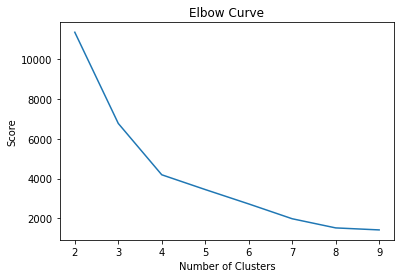

In [58]:
import pandas as pd

df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
plt.plot(df_cost.cluster, df_cost.cost)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

Looks like $k=4$

In [59]:
k_means = KMeans(featuresCol='standardized', k=4)
k_means_fitted = k_means.fit(data_scaled)

In [60]:
predictions = k_means_fitted.transform(data_scaled)

In [61]:
predictions.show(5, 0)

+-------+---------+------------------+----------+-----------------------------------+-----------------------------------------------------------+----------+
|recency|frequency|monetary_value    |CustomerID|features                           |standardized                                               |prediction|
+-------+---------+------------------+----------+-----------------------------------+-----------------------------------------------------------+----------+
|4586760|10       |153.0             |17714     |[4586760.0,10.0,153.0]             |[0.5284565819451322,0.2524151595200207,0.05460019967898049]|0         |
|1230360|43       |306.84            |17551     |[1230360.0,43.0,306.84]            |[0.1417540573655506,1.0853851859360888,0.10950016516012008]|0         |
|3148260|37       |236.01999999999995|13187     |[3148260.0,37.0,236.01999999999995]|[0.36272199083330764,0.9339360902240764,0.0842270531257057]|0         |
|4692360|30       |215.78            |15052     |[4692360.

In [62]:
predictions.select(F.min('recency'), F.max('recency'), F.min('frequency'), F.max('frequency'), F.min('monetary_value'), F.max('monetary_value')).show()


[Stage 1000:==============> (7 + 1) / 8][Stage 1001:==>             (1 + 7) / 8]



+------------+------------+--------------+--------------+-------------------+-------------------+
|min(recency)|max(recency)|min(frequency)|max(frequency)|min(monetary_value)|max(monetary_value)|
+------------+------------+--------------+--------------+-------------------+-------------------+
|        5220|    32243040|             1|           543|                0.0|           168469.6|
+------------+------------+--------------+--------------+-------------------+-------------------+



## Cluster Analysis

In [63]:
import seaborn as sns

In [64]:
df_viz = predictions.select(['recency', 'frequency', 'monetary_value', 'prediction']).toPandas()

In [65]:
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

<AxesSubplot:xlabel='prediction', ylabel='recency'>

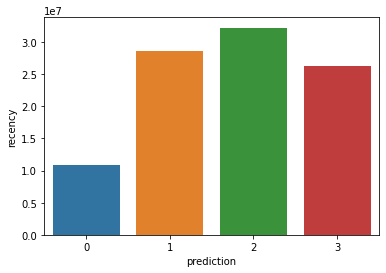

In [66]:
sns.barplot(x='prediction', y='recency', data=avg_df)

<AxesSubplot:xlabel='prediction', ylabel='frequency'>

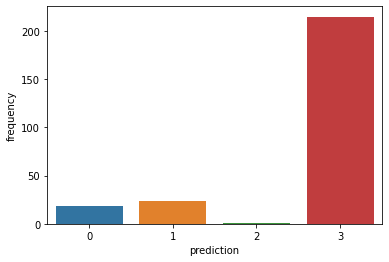

In [67]:
sns.barplot(x='prediction', y='frequency', data=avg_df)

<AxesSubplot:xlabel='prediction', ylabel='monetary_value'>

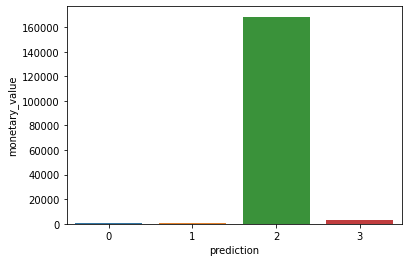

In [68]:
sns.barplot(x='prediction', y='monetary_value', data=avg_df)